## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Загрузим и изучим данные

In [2]:
data = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
df = data.copy()

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


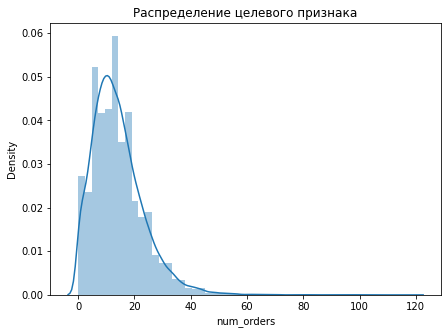

In [5]:
plt.figure(figsize=(7,5))
plt.title('Распределение целевого признака')
sns.distplot(a=df['num_orders'])
pass

Данные не содержат пропусков, распределение с хвостом вправо - учитывая, что у нас распределение величины по времени, это ожидаемый вид распределения. Проверим даты

In [6]:
df.index.is_monotonic

True

Даты непрерывные. Выполним ресемплирование данных по одному часу

In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные готовы к анализу

## Анализ

Для анализа времянного ряда разложим его на составляющие:

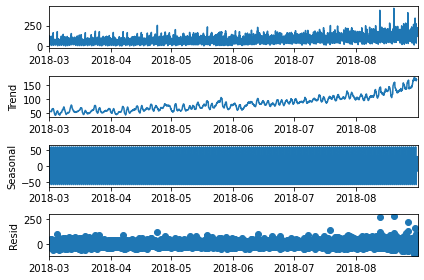

In [8]:
decomposed = seasonal_decompose(df)
decomposed.plot();

Рассмотрим сезонность, тренды и шум, присутствующие в данных

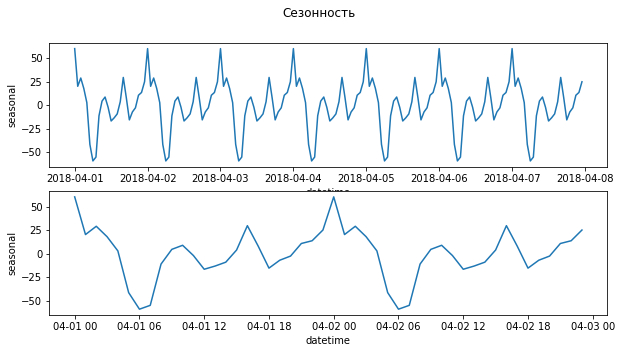

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
plt.suptitle('Сезонность')
sns.lineplot(data=decomposed.seasonal['2018-04-01':'2018-04-07'], ax=axes[0])
sns.lineplot(data=decomposed.seasonal['2018-04-01':'2018-04-02'], ax=axes[1])
pass

In [10]:
trend = pd.DataFrame(decomposed.trend)
trend['rolling_mean'] = trend.trend.rolling(500).mean()
trend.head()

,trend,rolling_mean
datetime,,
2018-03-01 00:00:00,NaN,NaN
2018-03-01 01:00:00,NaN,NaN
2018-03-01 02:00:00,NaN,NaN
2018-03-01 03:00:00,NaN,NaN
2018-03-01 04:00:00,NaN,NaN


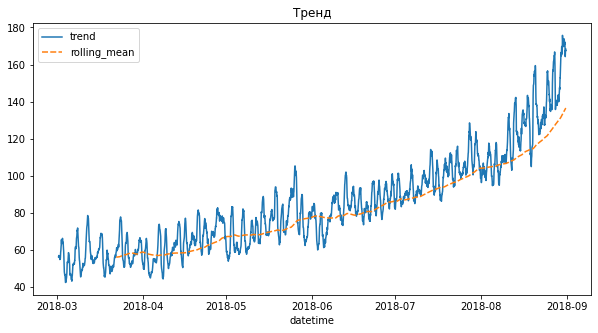

In [11]:
plt.figure(figsize=(10,5))
plt.title('Тренд')
sns.lineplot(data=trend)
pass

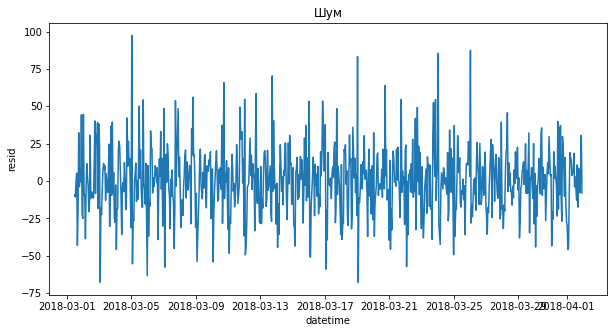

In [12]:
plt.figure(figsize=(10,5))
plt.title('Шум')
sns.lineplot(data=decomposed.resid['2018-03-01':'2018-04-01'])
pass

Ненулевой шум показывает, что библиотека корректно справилась с отделением случайных значений.  

График сезонности показывает, что абсолютный максимум заказов приходится на ночь (00:00-02:00). Локальный максимум заказов приходится на вечернее время, (15:00-18:00). Скорее всего подобные колебания приходятся на время, когда люди возвращаются с работы и ночное время, когда люди разъезжаются по домам после различных развлечений. Абсолютный минимум по заказам наблюдается около 6:00 утра.   

Анализ тренда временного ряда показывает, что количество заказов растет с каждым месяцем. Вероятно данный тренд на увеличение наблюдается благодаря расширению компании и увеличению количества частых клиентов.

## Обучение

Создадим дополнительные признаки для обучения моделей, разделим выборки на обучающую и тестовую и обучим модель. В качестве метрики валидации выберем RMSE. В качестве модели выберем LightGBM за его скорость. 

In [13]:
'''
Функция принимает на вход датафрейм,
максимальное смещение и размер окна
скользящего среднего. На основании входа
создает дополнительные признаки для 
обучения
'''

def make_time_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    print(data.head())

In [14]:
make_time_features(df, 25, 15)

                     num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   

                     lag_5  lag_6  lag_7  ...  lag_17  lag_18  lag_19  lag_20  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN 

In [15]:
df = df.dropna()

Разделим выборки на тестовую и обучающую

In [16]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False)

In [18]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3951, 28)
(440, 28)
(3951,)
(440,)


Обучим модель LGBMRegressor

In [19]:
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.3, max_depth=4, random_state=42)

In [20]:
model.fit(X_train, y_train,
          eval_set=(X_test,y_test),
          early_stopping_rounds=10,
          verbose=20,
          eval_metric='root_mean_squared_error')

Training until validation scores don't improve for 10 rounds
[20]	valid_0's rmse: 43.2538	valid_0's l2: 1870.89
[40]	valid_0's rmse: 41.4247	valid_0's l2: 1716
Early stopping, best iteration is:
[38]	valid_0's rmse: 41.1075	valid_0's l2: 1689.83


LGBMRegressor(learning_rate=0.3, max_depth=4, n_estimators=1000,
              random_state=42)

## Тестирование

In [21]:
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
score_train = mean_squared_error(y_train, preds_train) ** 0.5
score_test = mean_squared_error(y_test, preds_test) ** 0.5

In [22]:
d = {'RMSE':[round(score_train, 2), round(score_test, 2)]}
results = pd.DataFrame(d, index=['Обучающая выборка', 'Тестовая выборка'])
results

,RMSE
Обучающая выборка,17.56
Тестовая выборка,41.11


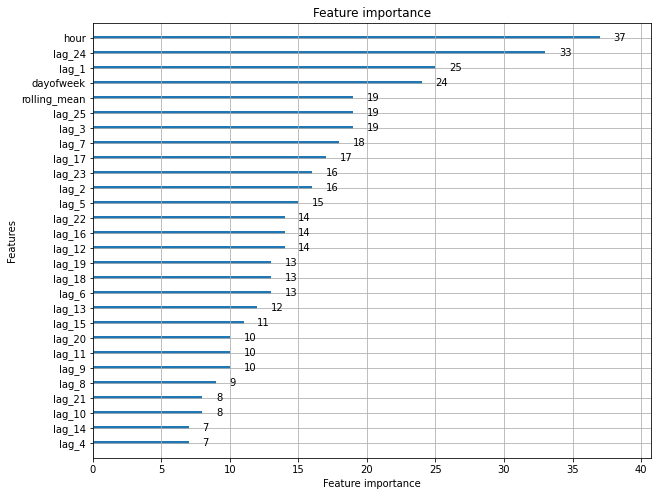

In [23]:
lgb.plot_importance(model, figsize=(10,8))
pass

## Результаты и выводы

Выведем график истинных значений и предсказанных значений для оценки адекватности модели

In [24]:
#Копируем датасет
df_fin = X_test.copy()

#Присоединяем таргет и предикт
df_fin['true'] = y_test
df_fin['predicted'] = preds_test

#Отбрасываем признаки и берем два дня
df_fin = df_fin[['true', 'predicted']]
df_fin = df_fin.iloc[8:56]

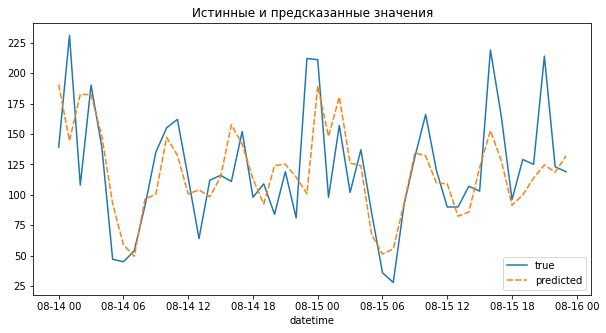

In [25]:
plt.figure(figsize=(10,5))
plt.title('Истинные и предсказанные значения')
sns.lineplot(data=df_fin)
pass

В ходе работы было проведено ресемплирование данных по одному часу, выполнена декомпозиция временого ряда, объяснены сезонность и тренды в данных.   
На основании 28 новых признаков была обучена ансамблевая модель с метрикой RMSE 41.11 на обучающей выборке.

Самыми значимыми признаками оказались час поездки и большие значения сдвига. Предположительно это сказывается влияние сезонности и тренда на рост количества заказов.